<a href="https://colab.research.google.com/github/hila-chefer/TargetCLIP/blob/main/TargetCLIP_CLIP_guided_image_essence_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import os
!git clone https://github.com/hila-chefer/TargetCLIP
os.chdir(f'./TargetCLIP')

Cloning into 'TargetCLIP'...
remote: Enumerating objects: 469, done.
remote: Counting objects: 100% (469/469), done.
remote: Compressing objects: 100% (328/328), done.
remote: Total 469 (delta 163), reused 421 (delta 123), pack-reused 0
Receiving objects: 100% (469/469), 42.49 MiB | 11.80 MiB/s, done.
Resolving deltas: 100% (163/163), done.


In [14]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# downloads StyleGAN's weights
ids = ['1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT']
for file_id in ids:
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.FetchMetadata(fetch_all=True)
  downloaded.GetContentFile(downloaded.metadata['title'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-r5iuw0x4
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-r5iuw0x4


In [15]:
import argparse
import os

import numpy as np
import torch
import torchvision
from torch import optim
from tqdm import tqdm
import clip
from criteria.clip_loss import CLIPLoss
from models.stylegan2_notebook.model import Generator
import math
import copy

In [16]:
#@title Aux functions
def get_latent(args, g_ema):
    mean_latent = g_ema.mean_latent(4096)
    latent_code_init_not_trunc = torch.randn(1, 512).cuda()
    with torch.no_grad():
        # _, latent_code_init = g_ema([latent_code_init_not_trunc], return_latents=True,
        #                             truncation=args.truncation, truncation_latent=mean_latent)
        _, latent_code_init,_ = g_ema([latent_code_init_not_trunc], return_latents=True,
                                    truncation=args.truncation, truncation_latent=mean_latent)

    direction = latent_code_init.detach().clone()
    direction.requires_grad = True
    return direction


def load_model(args):
    g_ema = Generator(args.stylegan_size, 512, 8)
    g_ema.load_state_dict(torch.load(args.ckpt)["g_ema"], strict=False)
    g_ema.eval()
    g_ema = g_ema.cuda()
    return g_ema


def get_lr(t, initial_lr, rampdown=0.75, rampup=0.005):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp

args = {
    "ckpt": "stylegan2-ffhq-config-f.pt",
    "stylegan_size": 1024,
    "lr": 0.1,
    "truncation": 0.7,
    "save_intermediate_image_every": 1,
    "results_dir": "results",
    "dir_name": "results",
    "num_batches": 1,
    "real_images": True,
    "data_path": "train_faces.pt",
}

from argparse import Namespace
a=Namespace(**args)

g_ema = load_model(a)


##**Option 1**: a celebrity source 

In [17]:
dirs = {
  'Elsa': 'dirs/elsa.npy',
  'Pocahontas': 'dirs/pocahontas.npy',
  'Keanu Reeves': 'dirs/keanu.npy',
  'Trump': 'dirs/trump.npy',
  'Joker': 'dirs/joker.npy',
  'Ariel': 'dirs/ariel.npy',
  'Doc Brown': 'dirs/doc.npy',
  'Beyonce': 'dirs/beyonce.npy',
  'Morgan Freeman': 'dirs/morgan.npy',
  'Avatar': 'dirs/avatar.npy',
  'Wolverine': 'dirs/wolverine.npy',
  'Grindelwald': 'dirs/grindelwald.npy',
  'Dumbledore': 'dirs/dumbledore.npy',
  'Gargamel': 'dirs/gargamel.npy',
  'Ed Sheeran': 'dirs/ed.npy',
  'Zendaya': 'dirs/zendaya.npy',
  'Moana': 'dirs/moana.npy',
  'Megan Fox': 'dirs/megan.npy',
  'Thanos': 'dirs/thanos.npy',
}

targets = {
  'Elsa': 'dirs/targets/elsa.jpg',   
  'Pocahontas': 'dirs/targets/pocahontas.jpg',
  'Keanu Reeves': 'dirs/targets/keanu.jpg',
  'Trump': 'dirs/targets/trump.jpg',
  'Joker': 'dirs/targets/joker.jpg',
  'Ariel': 'dirs/targets/ariel.jpeg',
  'Doc Brown': 'dirs/targets/doc_brown.jpg',
  'Beyonce': 'dirs/targets/beyonce.jpg',
  'Grindelwald': 'dirs/targets/grindelwald.jpg',
  'Dumbledore': 'dirs/targets/dumbledore.jpg',
  'Morgan Freeman': 'dirs/targets/morgan_freeman.jpg',
  'Avatar': 'dirs/targets/avatar.jpg',
  'Wolverine': 'dirs/targets/wolverine.jpg',
  'Gargamel': 'dirs/targets/Gargamel.png',
  'Ed Sheeran': 'dirs/targets/ed_sheeran.jpg',
  'Zendaya': 'dirs/targets/zendaya_2.jpg',
  'Moana': 'dirs/targets/moana.jpg',
  'Megan Fox': 'dirs/targets/megan.jpg',
  'Thanos': 'dirs/targets/thanos.jpg',
}

sources_ids = {
  'Taylor Swift': 67,   
  'Elon Musk': 4,
  'Hillary Clinton': 9,
  'Alfie Allen': 34,
  'Obama': 61
}

target = 'Joker' #@param ['Trump','Ed Sheeran', 'Avatar', 'Zendaya', 'Keanu Reeves','Megan Fox', 'Elsa', 'Pocahontas', 'Moana', 'Thanos', 'Joker', 'Ariel', 'Doc Brown', 'Beyonce', 'Morgan Freeman','Wolverine', 'Grindelwald', 'Dumbledore', 'Gargamel']
source_name = 'Hillary Clinton' #@param ['Taylor Swift', 'Elon Musk', 'Hillary Clinton', 'Alfie Allen', 'Obama']

sources = torch.from_numpy(np.load('dirs/w_plus.npy'))
source = sources[sources_ids[source_name]].unsqueeze(0)
dir = torch.from_numpy(np.load(dirs[target]))
target_path = targets[target]

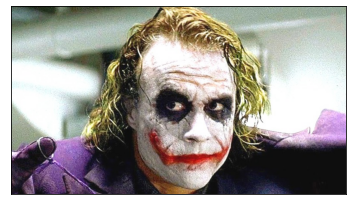

In [ ]:
#@title Show target image
assert(target_path is not None)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(target_path)
imgplot = plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:69: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


(-0.5, 1023.5, 1023.5, -0.5)

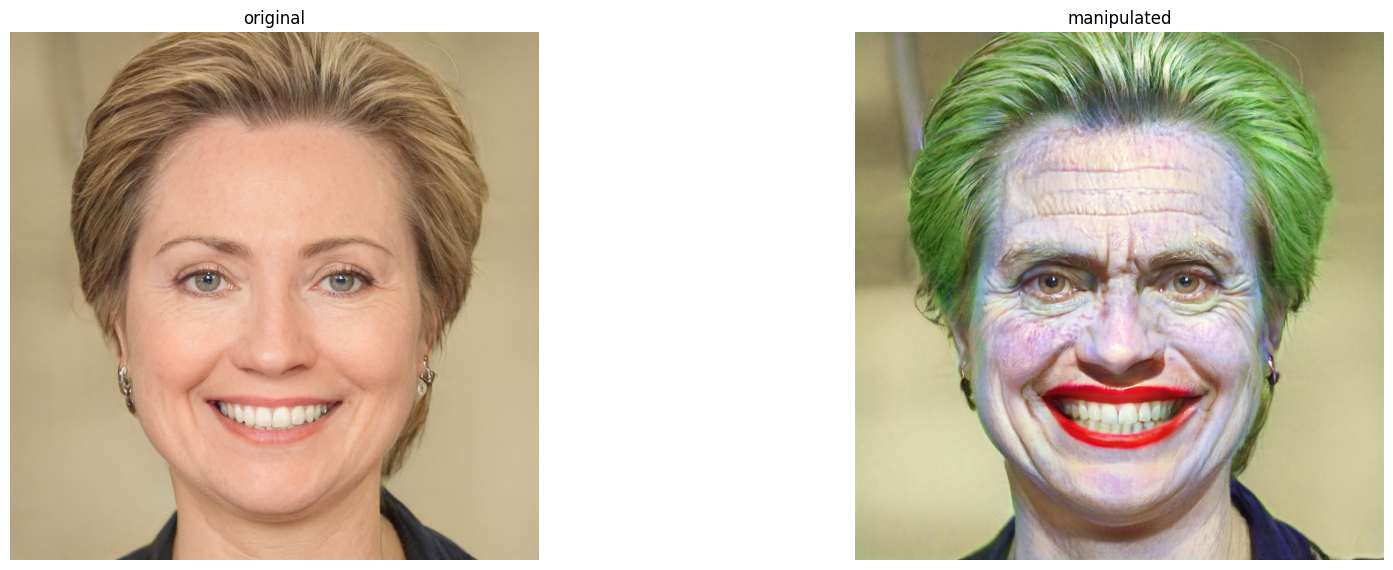

In [18]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#alpha=1
alpha = 1.1 #@param {type:"slider", min:0, max:2, step:0.1}
dir = dir.cuda()
source = source.cuda()
source_img, _ = g_ema([source], input_is_latent=True, randomize_noise=False)
source_amp, _ = g_ema([source + dir * alpha], input_is_latent=True,
                        randomize_noise=False)

torchvision.utils.save_image(source_img, f"results_orig.png", normalize=True, range=(-1, 1))
torchvision.utils.save_image(source_amp, f"results_manipulated.png", normalize=True, range=(-1, 1))
plt.figure(figsize=(20,7), dpi= 100)
plt.subplot(1,2,1)
plt.imshow(mpimg.imread('results_orig.png'))
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mpimg.imread('results_manipulated.png'))
plt.title('manipulated')
plt.axis('off')

##**Option 2**: your own inverted source

In [19]:
target = 'Elsa' #@param ['Trump','Ed Sheeran', 'Avatar', 'Zendaya', 'Keanu Reeves','Megan Fox', 'Elsa', 'Pocahontas', 'Moana', 'Thanos', 'Joker', 'Ariel', 'Doc Brown', 'Beyonce', 'Morgan Freeman','Wolverine', 'Grindelwald', 'Dumbledore', 'Gargamel']
latent_path = "dirs/me.pt" #@param {type:"string"}
source = torch.load(latent_path).unsqueeze(0)
dir = torch.from_numpy(np.load(dirs[target]))
target_path = targets[target]

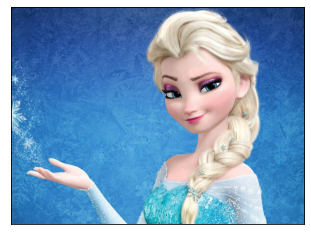

In [20]:
#@title Show target image
assert(target_path is not None)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(target_path)
imgplot = plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:69: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


(-0.5, 1023.5, 1023.5, -0.5)

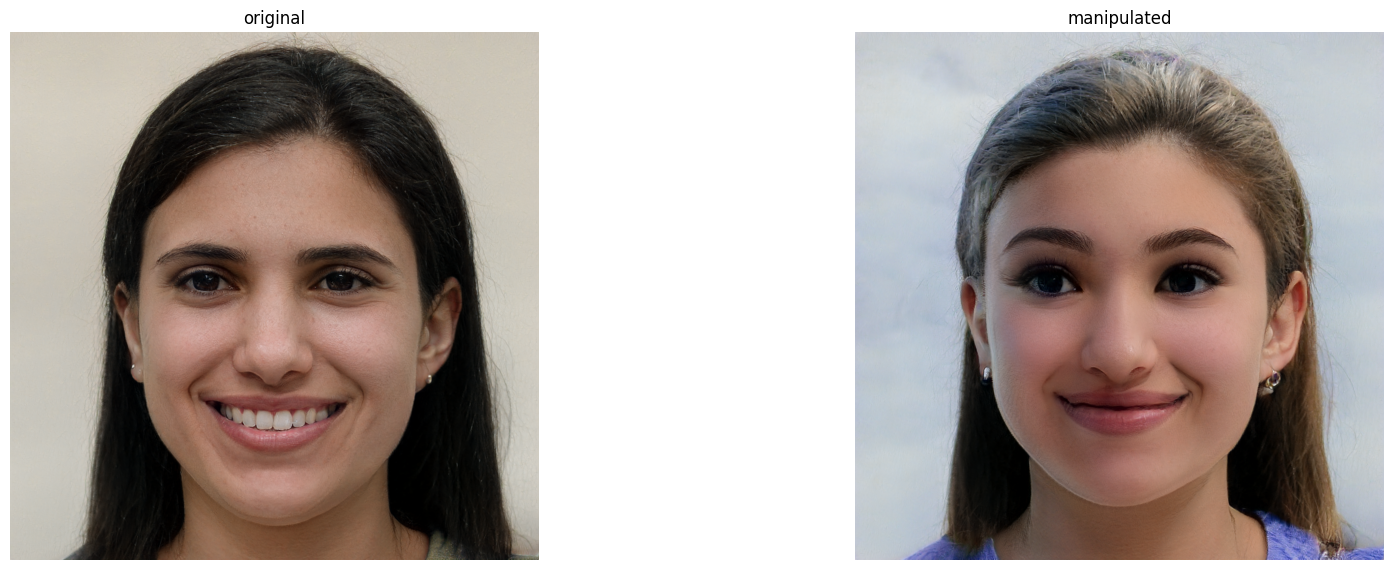

In [21]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#alpha=1
alpha = 0.8 #@param {type:"slider", min:0, max:2, step:0.1}
dir = dir.cuda()
source = source.cuda()
source_img, _ = g_ema([source], input_is_latent=True, randomize_noise=False)
source_amp, _ = g_ema([source + dir * alpha], input_is_latent=True,
                        randomize_noise=False)

torchvision.utils.save_image(source_img, f"results_orig.png", normalize=True, range=(-1, 1))
torchvision.utils.save_image(source_amp, f"results_manipulated.png", normalize=True, range=(-1, 1))
plt.figure(figsize=(20,7), dpi= 100)
plt.subplot(1,2,1)
plt.imshow(mpimg.imread('results_orig.png'))
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mpimg.imread('results_manipulated.png'))
plt.title('manipulated')
plt.axis('off')